In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import imageio 
import os
import netCDF4 as nc
import matplotlib as mpl
import shapefile
import pyproj

import fiona
from shapely.geometry import shape
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

from scipy.ndimage import binary_dilation

from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal

In [15]:
common_years = np.arange(2005,2017,1)

In [16]:

shp = '/Users/francesco/Desktop/Thesis/Data/GEOTIFFs/roi.shp'

regions = []
boundaries = []

with fiona.open(shp, 'r') as shapefile:
    for feature in shapefile:
        # Accessing properties
        properties = feature['properties']
        id = properties['id']

        # Accessing geometry and extracting bounds
        geom = shape(feature['geometry'])
        bounds = geom.bounds
        xmin, ymin, xmax, ymax = bounds

        # Taking the info
        regions.append(id)
        boundaries.append([xmin, xmax, ymin, ymax])

#Create daatset with the boundaries
df_region = pd.DataFrame(boundaries, index=regions, columns=['xmin', 'xmax', 'ymin', 'ymax'])

In [17]:
#Importing the coastlines and creatiing the file names

root = '/Users/francesco/Desktop/Thesis/Coastlines/dataset/JPL_iceshelves_geometryJPL_antarctic_coastline_'
end = '_filled.tif'

file_names = [] 

for year in common_years:

    file_names.append(root+str(year)+end)

In [18]:
#Preparing the masks dataframe

ice_mask = pd.DataFrame(index = regions, columns = common_years)
grounded_ice_mask = pd.DataFrame(index = regions, columns = common_years)
sea_mask = pd.DataFrame(index = regions, columns = common_years)
land_mask = pd.DataFrame(index = regions, columns = common_years)


In [19]:
for file, year in zip(file_names, common_years):

    for id in df_region.index:#df_region.index:

        with rasterio.open(file, crs='EPSG:3031') as src:

            xmin, xmax, ymin, ymax = df_region.loc[id]
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
            image = src.read(1, window=window)

            # Initialize boolean masks with the same shape as the window
            ice_mask_tmp = np.zeros_like(image, dtype=bool)
            sea_mask_tmp = np.zeros_like(image, dtype=bool)
            land_mask_tmp = np.zeros_like(image, dtype=bool)
            grounded_ice_mask_tmp = np.zeros_like(image, dtype=bool)

            # Update masks based on conditions
            ice_mask_tmp[image == 3] = True
            sea_mask_tmp[image == 0 ] = True
            land_mask_tmp[image == 2] = True
            grounded_ice_mask_tmp[image == 1] = True

            #save the masks
            ice_mask.loc[id, year] = ice_mask_tmp 
            sea_mask.loc[id, year] = sea_mask_tmp 
            land_mask.loc[id, year] = land_mask_tmp
            grounded_ice_mask.loc[id, year] = grounded_ice_mask_tmp


In [8]:
#I will need to save the mask as i did with definitve thickness, ice calving and so on

In [20]:
#Save all the datasets

np.save(os.getcwd()+'/ice_mask.npy', ice_mask)
np.save(os.getcwd()+'/sea_mask.npy', sea_mask)
np.save(os.getcwd()+'/land_mask.npy', land_mask)
np.save(os.getcwd()+'/grounded_ice_mask.npy', grounded_ice_mask)

In [21]:
#load the datasets
ice_mask = np.load(os.getcwd()+'/ice_mask.npy', allow_pickle=True)
sea_mask = np.load(os.getcwd()+'/sea_mask.npy', allow_pickle=True)
land_mask = np.load(os.getcwd()+'/land_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(os.getcwd()+'/grounded_ice_mask.npy', allow_pickle=True)

In [25]:
#crete the dataframes
ice_mask = pd.DataFrame(ice_mask, index = regions, columns = common_years)
sea_mask = pd.DataFrame(sea_mask, index = regions, columns = common_years)
land_mask = pd.DataFrame(land_mask, index = regions, columns = common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = regions, columns = common_years)


Now I will extract the front

In [50]:
#Here i expand the front of the sea by 1 pixels
sea_mask = np.load(os.getcwd()+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = regions, columns = common_years)

for year in common_years:
    
        for id in df_region.index:
    
            sea_mask.loc[id, year] = binary_dilation(sea_mask.loc[id, year], iterations=3)

In [51]:
#Here I select the borders of the ice shelves

borders = pd.DataFrame(index = regions, columns = common_years)

for year in common_years:
    
        for id in df_region.index:
    
            borders.loc[id, year] = ice_mask.loc[id, year] & sea_mask.loc[id, year]

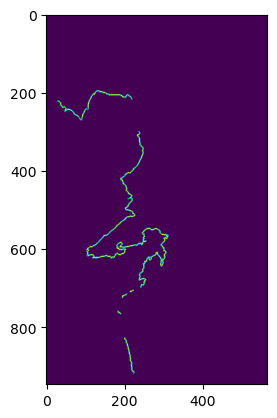

In [52]:
plt.imshow(borders.loc[1, 2005])

In [53]:
#Save the borders
np.save(os.getcwd()+'/borders_expanded_by_3.npy', borders)

MovieWriter imagemagick unavailable; using Pillow instead.


type: list index out of range

Error in callback <function _draw_all_if_interactive at 0x1084476d0> (for post_execute):


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

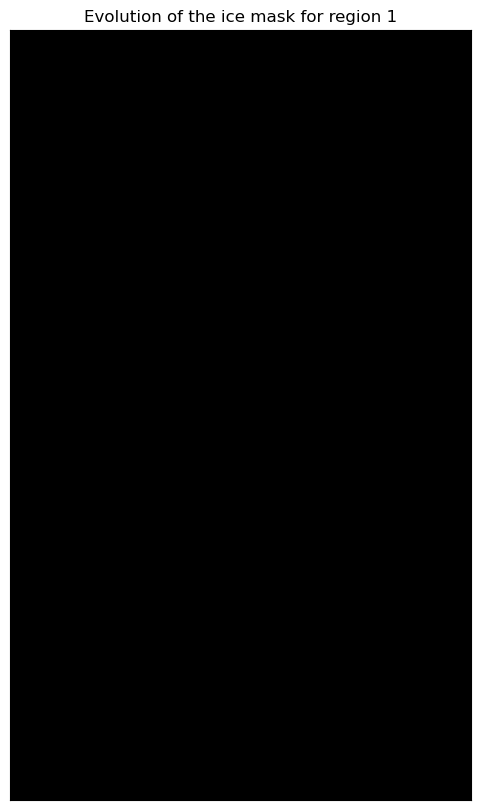

In [13]:
#I would like now to create a gif for the evolution of the ice mask

id = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Evolution of the ice mask for region '+str(id))

ax.set_xlim(df_region.loc[id][0], df_region.loc[id][1])
ax.set_ylim(df_region.loc[id][2], df_region.loc[id][3])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('black')

def animate(i):
    ax.imshow(ice_mask.loc[id,2005+i], cmap='Blues', extent=[df_region.loc[id][0], df_region.loc[id][1], df_region.loc[id][2], df_region.loc[id][3]])
    ax.set_title('Evolution of the ice mask for region '+str(id)+', year '+str(2005+i))
    return ax

anim = animation.FuncAnimation(fig, animate, frames=12, interval=1000, blit=False)
anim.save('ice_mask_region_'+str(id)+'.gif', writer='imagemagick')



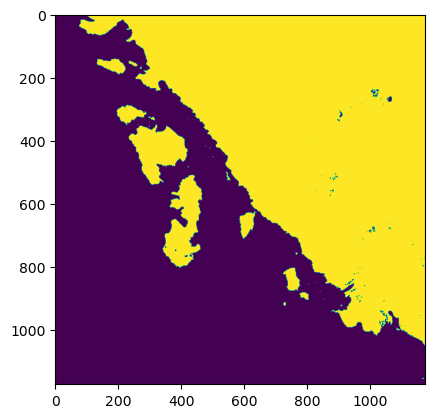

In [ ]:
plt.imshow(sea_mask.loc[2,2005])